# Hyperbolic Embedding of Heterogeneous Multilayer SBM Networks


This notebook demonstrates the application of MLNHypEmb to multilayer networks where each layer can have a different number of nodes - a common scenario in real-world systems. We use a generalized Stochastic Block Model (SBM) approach to generate test networks with the following characteristics:

 - Heterogeneous Layer Structure: Each layer contains a different subset of nodes
 - Community Structure: Clear community organization within each layer
 - Variable Node Participation: Nodes can be present in some layers and absent in others
 
The visualization showcases how our embedding method successfully maps these heterogeneous layers into hyperbolic space while preserving both the community structure and the topological relationships between nodes. This approach is particularly relevant for analyzing real-world multilayer systems where node participation varies across layers, such as temporal networks or multi-modal biological networks.

### Libriaries importation 

In [1]:
# Import libraries

from src.OpenData import generate_sbm_multilayer  # For generating multilayer stochastic block models
import numpy as np                                # For numerical operations
import matplotlib.pyplot as plt                   # For plotting
import networkx as nx                            # For graph operations
from src.EmbeddingMethodUnSym import MlHypEmbUnsym  # For embedding the multilayer network

### Generate networks 

In [2]:
# Parameters for the Stochastic Block Model
n_nodes = 100          # Total number of nodes per layer initially
n_layers = 3           # Number of layers in the multilayer network
n_communities = 3      # Number of communities in each layer
p_intra = 0.16        # Probability of connection within communities
p_inter = 0.06        # Probability of connection between communities
mu = 20               # Coupling parameter for emebdding
beta = 10             # Parameter for inter layers connexions

# Define layer names (using simple numerical indices)
layers_names = np.arange(n_layers)

# Generate multilayer stochastic block model
# Returns:
# - G_tot: list of networkx graphs (one per layer)
# - mat_tot: list of adjacency matrices (one per layer)
# - G_global: global adjacency matrix connecting all layers
# - node_com: dictionary mapping nodes to their community assignments
G_tot, mat_tot, G_global, node_com = generate_sbm_multilayer(
    n_nodes=n_nodes, 
    n_layers=n_layers, 
    n_communities=n_communities, 
    p_intra=p_intra, 
    p_inter=p_inter, 
    mu=mu, 
    beta=beta
)


In [3]:
## REMOVE SOME NODES FROM EACH LAYER TO CREATE UNEQUAL LAYER SIZES

# Specify number of nodes to remove from each layer 
n_nodes_to_remove_tot = [0, 10, 15]

# Randomly select which nodes to remove from each layer
nodes_to_remove = []
for i in range(n_layers):
    random_indices = np.random.choice(n_nodes-1, size=n_nodes_to_remove_tot[i], replace=False)
    nodes_to_remove.append(random_indices)
    
# Remove selected nodes from each layer's graph
for i in range(n_layers):
    G_tot[i].remove_nodes_from(nodes_to_remove[i])

# Update adjacency matrices by removing rows and columns corresponding to removed nodes
for i in range(n_layers):
        indices_to_keep = np.delete(np.arange(mat_tot[i].shape[0]), nodes_to_remove[i])
        reduced_matrix = mat_tot[i].copy()
        reduced_matrix = mat_tot[i][indices_to_keep,:][:,indices_to_keep]
        mat_tot[i] = reduced_matrix

# Store new number of nodes per layer after removal
n_nodes_per_layer = []
for i in range(n_layers):
    n_nodes_per_layer.append(len(G_tot[i]))

## Update global connectivity matrix G_global
# Calculate global indices of removed nodes across all layers
nodes_to_remove_global = []
for i in range(n_layers):
    nodes_to_remove_global = nodes_to_remove_global + list(nodes_to_remove[i] + sum(n_nodes_per_layer[:i]))

# Remove nodes from global connectivity matrix
indices_to_keep = np.delete(np.arange(G_global.shape[0]), np.array(nodes_to_remove_global).astype(int))
G_global = G_global[:,indices_to_keep][indices_to_keep,:]

# Update community assignments for each layer
node_com_tot = []
for i in range(n_layers):
     # Create copy of community assignments
     node_com_loc = node_com.copy()

     # Remove nodes from the community assignments
     for node in nodes_to_remove[i]:
         del node_com_loc[node]

     # Store updated community assignments for this layer
     node_com_tot.append(node_com_loc)


### Embedding 

In [4]:
# Initiate embedding object with parameters for the multilayer hyperbolic embedding
Emb_obj = MlHypEmbUnsym(
    preweight=True,     
    weight='weight',     
    beta=2500,        
    eta='auto',        
    method='Isomap',    
    beta_dist=100,        
    metric='precomputed', 
    n_neighbors='auto',   
    radius='degree'     
)

# Load network data into the embedding object
Emb_obj.Load_data(matrices=mat_tot, L_global=G_global)

# Perform the embedding computation
Emb_obj.Embedding(n_jobs=-1)

[I] Object of class MlHypEmb well initiated


### Vizualisation 

Plotting layer: 0 0
Plotting layer: 1 1
Plotting layer: 2 2


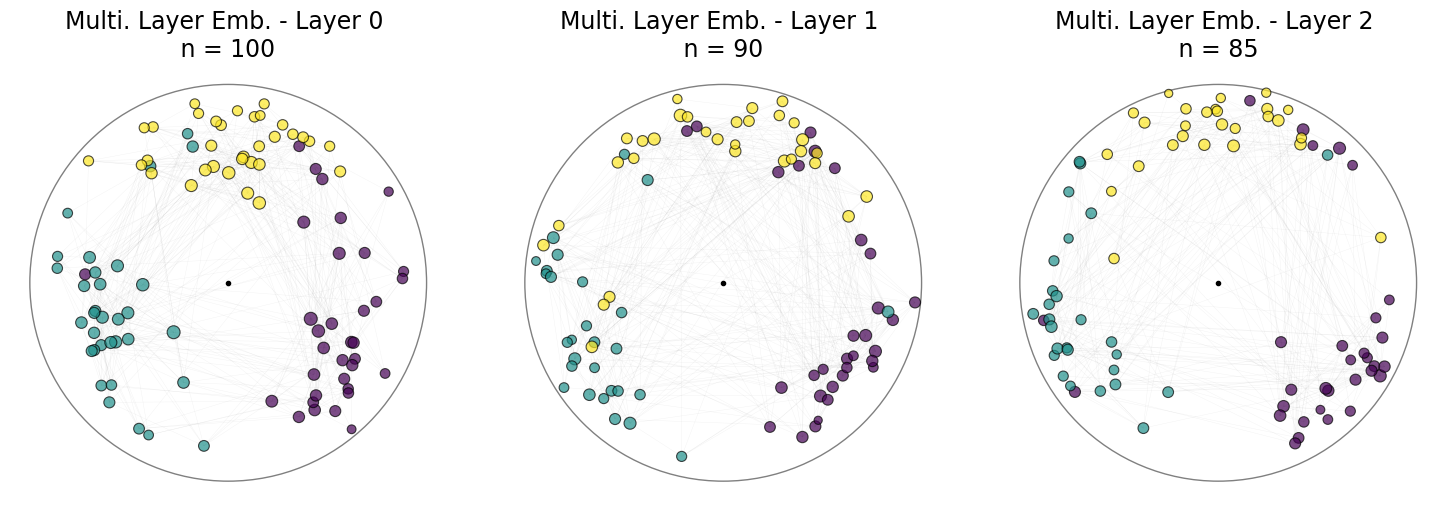

In [5]:
## Visualization of Multilayer Network Embeddings

# Set up the main figure with appropriate size for 3 layers
fig = plt.figure(figsize=(15, 5))
plt.rcParams['axes.linewidth'] = 2  # Enhance axes visibility

# Plot each layer of the multilayer network
for layer_i in range(len(layers_names)):
    # Get layer identification
    layer_id = list(layers_names)[layer_i]
    layer_name = layers_names[layer_id]
    print('Plotting layer:', layer_name, layer_id)
    
    # Create subplot for current layer
    ax1 = fig.add_subplot(1, 3, layer_i + 1)
    
    # Get network and embedding data for current layer
    G = G_tot[layer_i]  # Network graph
    pos_G = Emb_obj.embeddings[layer_i]  # Node positions from embedding
    pos_G_d = {node: pos_G[i, :] for i, node in enumerate(G.nodes())}  # Map nodes to positions
    
    # Setup hyperbolic visualization
    ax1.plot([0], [0], 'o', color='black', markersize=3)  # Origin point
    circle = plt.Circle((0, 0), 1, edgecolor='gray', facecolor='none', linewidth=1)  # Unit circle
    ax1.add_artist(circle)
    
    # Calculate node sizes based on weighted degree
    deg = np.array(list(dict(G.degree(weight='weight')).values()))
    node_size = np.sqrt(deg + 1) * 20  # Scale node sizes for better visibility
    
    # Draw the network
    nx.draw_networkx_nodes(
        G, pos_G_d, 
        node_size=node_size, 
        node_color=list(node_com_tot[layer_i].values()),  # Color nodes by community
        node_shape='o', 
        edgecolors='k', 
        linewidths=0.8, 
        alpha=0.7,
        ax=ax1
    )
    nx.draw_networkx_edges(
        G, pos_G_d, 
        width=0.3,
        edge_color='grey', 
        alpha=0.1,
        ax=ax1
    )
    
    # Set plot properties
    ax1.set_xlim(-1.1, 1.1)
    ax1.set_ylim(-1.1, 1.1)
    ax1.axis("off")
    ax1.set_title(f'Multi. Layer Emb. - Layer {layer_name} \n n = {str(n_nodes_per_layer[layer_i])} ', fontsize=17)
    ax1.set_aspect('equal', 'box')

# Adjust layout and display
fig.tight_layout()
plt.show()